In [1]:
import os
import numpy as np
import tensorflow as tf
from keras import optimizers
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from segnet import segnet
from generator import DataGenerator

Using TensorFlow backend.


In [2]:
# hyperparameters
nv=int(2**16) # variants
na=2          # alleles
nc=7          # ancestry classes
ne=100        # number of epochs
nf=8          # number of segnet filters
fs=16          # filter size
bs=32         # batch size
dp=5          # number of segnet blocks (depth)
wt=False      # use inverse frequency weighted loss -- this doesn't seem to help
gen=True      # use data generator
hor=False     # use multi-gpu
oce=True      # include oceanian samples
dev=True      # do we have a dev set

# reproducibility
# np.random.seed(23910464)
np.random.seed(1)

In [3]:
# configure horovod if we're using multiple gpus
# - note that this doesn't work within a jupyter notebook
# - but you can use it to assign one of the two gpus to the tf instance
# - ((probably))
if hor: 
    import horovod.keras as hvd 

    # initialize horovod instance -- this currently only works on galangal
    hvd.init()

    # assign GPUs to horovod 
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    if gpus:
        # tf.config in tf <= 1.6
        tf.config.experimental.set_visible_devices(gpus[hvd.local_rank()], 'GPU')
    print(gpus)

In [4]:
# sanity check that we're on gpu -- use #1
os.environ["CUDA_VISIBLE_DEVICES"]="1"
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# declare model
model=segnet(input_shape=(nv, na), n_classes=nc-1+int(oce), n_filters=nf, width=fs, n_blocks=dp)

# and optimizer
if hor:
    adam=optimizers.Adam(lr=1e-5 * hvd.size())
    adam=hvd.DistributedOptimizer(adam)
else:
    adam=optimizers.Adam(lr=1e-4)

# now compile and show parameter summary
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 
print(model.summary())

Model: "segnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 65536, 2)     0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 65536, 2)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_down1 (Conv1D)            (None, 65536, 8)     264         dropout_1[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 65536, 8)     0           conv1_down1[0][0]                
_____________________________________________________________________________________________

In [6]:
# load data
data_root='/home/magu/deepmix/data/reference_panel/'
X = np.load(data_root+'unzipped/panel_chr20.G.npy', mmap_mode='r')
Y = np.load(data_root+'unzipped/panel_chr20.L.npy', mmap_mode='r')
S = np.load(data_root+'unzipped/panel_chr20.S.npy')
print([X.shape, Y.shape, X.shape])

[(2764, 516801, 2), (2764, 516801, 7), (2764, 516801, 2)]


In [7]:
# and train individuals
train=np.loadtxt('../data/reference-panel/split/train.strands.txt', dtype=str)
train_ix=[i for i,q in enumerate(S) if q in train]
np.random.shuffle(train_ix)
print(len(train_ix))

2090


In [8]:
# and some dev individuals, why not -- first pick their indexes
if dev:
    #n=100
    S=np.load(data_root+'simulated_chr20/label/dev_10gen.result.npz')['S']
    s=S#np.random.choice(S, size=min(n, S.shape[0]), replace=False)

    # then load and subset -- AMR is the first ancestry label, ignored for now
    x_f=data_root+'simulated_chr20/numpy/dev_10gen.query.npz'
    y_f=data_root+'simulated_chr20/label/dev_10gen.result.npz'
    S_f=np.load(x_f)['S']
    X_dev=np.load(x_f)['G'][[np.where(S_f==(i))[0][0] for i in s],:nv,:na]
    S_f=np.load(y_f)['S']
    Y_dev=to_categorical(np.load(y_f)['L'][[np.where(S_f==(i))[0][0] for i in s],:nv], dtype='bool')[:,:,1:]
    print([X_dev.shape, Y_dev.shape])

[(200, 65536, 2), (200, 65536, 7)]


In [9]:
# now try it out!
if not oce:
    train_ix=[i for i in train_ix if Y[i,0,:].dot(np.arange(nc))!=4]
    Y=Y[:,:,[i for i in range(nc) if i!=4]]
    if dev:
        Y_dev=Y_dev[:,:,[i for i in range(nc) if i!=4]]

nes=[ne]        
cws=[np.ones((nc,))]
if wt:
    nes.append(ne)
    cws.append(Y.sum()/Y.sum(axis=0).sum(axis=0))
for ne,cw in zip(nes,cws):
    if dev:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

        # fit with generator, or not
        if gen:
            params={'X':X, 'Y':Y, 'dim':nv, 'batch_size':bs, 'n_classes':nc, 'n_alleles':na}
            generator=DataGenerator(train_ix, **params)
            history=model.fit_generator(generator=generator, epochs=ne, validation_data=(X_dev, Y_dev), 
                                        callbacks=[es], class_weight=cw)
        else:
            history=model.fit(X[train_ix,:nv,:na], Y[train_ix,:nv,:], batch_size=bs, epochs=ne, 
                               validation_data=(X_dev, Y_dev), callbacks=[es], class_weight=cw)
    else:
        history=model.fit(X[train_ix,:nv,:na], Y[train_ix,:nv,:], batch_size=bs, epochs=ne, class_weight=cw)

Epoch 1/100
65/65 [==============================] - 265s 4s/step - loss: 1.9315 - accuracy: 0.1783 - val_loss: 1.8630 - val_accuracy: 0.2683
Epoch 2/100
65/65 [==============================] - 96s 1s/step - loss: 1.8815 - accuracy: 0.2702 - val_loss: 1.8630 - val_accuracy: 0.2689
Epoch 3/100
65/65 [==============================] - 96s 1s/step - loss: 1.8529 - accuracy: 0.3018 - val_loss: 1.7499 - val_accuracy: 0.3910
Epoch 4/100
65/65 [==============================] - 93s 1s/step - loss: 1.7714 - accuracy: 0.3301 - val_loss: 1.6455 - val_accuracy: 0.4043
Epoch 5/100
65/65 [==============================] - 94s 1s/step - loss: 1.6775 - accuracy: 0.3285 - val_loss: 1.6435 - val_accuracy: 0.3541
Epoch 6/100
65/65 [==============================] - 97s 1s/step - loss: 1.5960 - accuracy: 0.3602 - val_loss: 1.5115 - val_accuracy: 0.3729
Epoch 7/100
65/65 [==============================] - 98s 2s/step - loss: 1.5460 - accuracy: 0.3821 - val_loss: 1.5610 - val_accuracy: 0.3270
Epoch 8/100


Epoch 59/100
65/65 [==============================] - 92s 1s/step - loss: 0.1402 - accuracy: 0.9516 - val_loss: 1.0846 - val_accuracy: 0.7707
Epoch 60/100
65/65 [==============================] - 91s 1s/step - loss: 0.1273 - accuracy: 0.9570 - val_loss: 1.2873 - val_accuracy: 0.7658
Epoch 61/100
65/65 [==============================] - 91s 1s/step - loss: 0.1296 - accuracy: 0.9562 - val_loss: 1.1144 - val_accuracy: 0.7928
Epoch 00061: early stopping


In [10]:
# save
model.save('chm20_short.h5')

0.7927744388580322


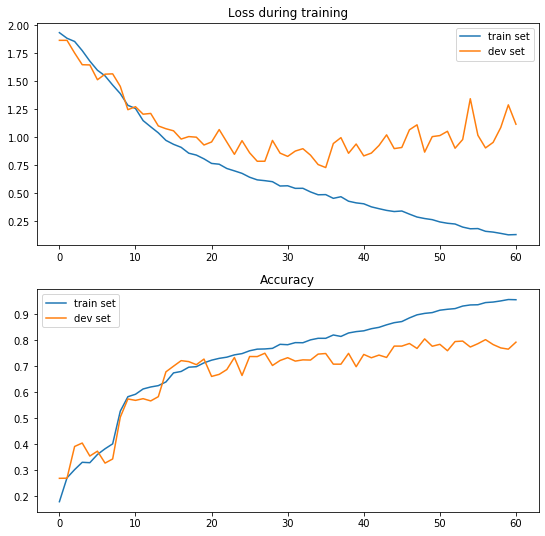

In [11]:
_, dev_acc = model.evaluate(X_dev, Y_dev, verbose=0)

# 1.1) plot loss during training
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1, (9,9))
plt.subplot(211)
plt.title('Loss during training')
plt.plot(history.history['loss'], label='train set')
plt.plot(history.history['val_loss'], label='dev set')
plt.legend()

# 1.2) plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train set')
plt.plot(history.history['val_accuracy'], label='dev set')
plt.legend()

print(dev_acc)

In [12]:
Y_hat_p=model.predict(X_dev)
Y_hat=np.argmax(Y_hat_p, axis=-1)

In [13]:
Y_hat.shape

(200, 65536)

In [14]:
Y.sum(axis=0).sum(axis=0)/Y.sum().sum().sum()

array([0.276411  , 0.36324168, 0.1121563 , 0.05499276, 0.01447178,
       0.13096961, 0.04775687])

In [15]:
Y_dev.sum(axis=0).sum(axis=0)/Y_dev.sum().sum().sum()

array([0.26845955, 0.34897385, 0.19985161, 0.08600426, 0.01418495,
       0.04849976, 0.03402603])

In [16]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [17]:
anc=['AFR','EAS','EUR','NAT','OCE','SAS','WAS']
if not oce:
    anc.remove('OCE')
pd.DataFrame(confusion_matrix(Y_dev.dot(np.arange(nc-int(not oce))).flatten(), Y_hat.flatten())/(Y_hat.shape[0]*nv), 
             columns=anc, index=anc)

,AFR,EAS,EUR,NAT,OCE,SAS,WAS
AFR,0.246397,0.007175,0.000785,0.000064,0.002166,0.003985,7.888947e-03
EAS,0.000971,0.333937,0.000520,0.003439,0.000778,0.009114,2.157593e-04
EUR,0.000078,0.009259,0.109031,0.001968,0.000166,0.047808,3.154327e-02
NAT,0.000000,0.018423,0.000626,0.062193,0.000065,0.004697,7.629395e-07
OCE,0.000355,0.000751,0.000000,0.001582,0.010178,0.000729,5.918121e-04
SAS,0.001254,0.013494,0.005849,0.001090,0.000009,0.022344,4.460220e-03
WAS,0.000648,0.000685,0.014696,0.000128,0.000139,0.009037,8.694687e-03


In [18]:
for i in range(Y_hat.shape[0]):
    print((i, [np.count_nonzero(Y_hat[i,:]==j) for j in range(Y_hat_p.shape[-1])], 
           [np.count_nonzero(Y_dev[i,:,:].argmax(axis=-1)==j) for j in range(Y_hat_p.shape[-1])]))

(0, [40296, 12073, 0, 0, 323, 0, 12844], [43355, 12094, 0, 0, 0, 0, 10087])
(1, [0, 36766, 0, 19933, 0, 8837, 0], [0, 17771, 0, 47765, 0, 0, 0])
(2, [0, 36766, 0, 19933, 0, 8837, 0], [0, 17771, 0, 47765, 0, 0, 0])
(3, [0, 65360, 0, 176, 0, 0, 0], [0, 65536, 0, 0, 0, 0, 0])
(4, [0, 65536, 0, 0, 0, 0, 0], [0, 65536, 0, 0, 0, 0, 0])
(5, [0, 65536, 0, 0, 0, 0, 0], [0, 62065, 3471, 0, 0, 0, 0])
(6, [0, 18873, 30411, 1303, 0, 6605, 8344], [0, 17779, 47757, 0, 0, 0, 0])
(7, [13224, 52312, 0, 0, 0, 0, 0], [16451, 45841, 0, 3244, 0, 0, 0])
(8, [13224, 52312, 0, 0, 0, 0, 0], [16451, 45841, 0, 3244, 0, 0, 0])
(9, [0, 64620, 0, 0, 0, 916, 0], [0, 65536, 0, 0, 0, 0, 0])
(10, [0, 64620, 0, 0, 0, 916, 0], [2500, 63036, 0, 0, 0, 0, 0])
(11, [0, 62441, 1, 1492, 0, 1602, 0], [0, 65536, 0, 0, 0, 0, 0])
(12, [64387, 0, 0, 0, 0, 0, 1149], [65536, 0, 0, 0, 0, 0, 0])
(13, [0, 17608, 21419, 1316, 0, 25193, 0], [0, 0, 25196, 0, 0, 40340, 0])
(14, [0, 17608, 21419, 1316, 0, 25193, 0], [0, 0, 25196, 0, 0, 40340,

(121, [454, 16388, 26524, 358, 1087, 9939, 10786], [2356, 8776, 54404, 0, 0, 0, 0])
(122, [0, 50793, 3141, 0, 0, 10081, 1521], [0, 53333, 12203, 0, 0, 0, 0])
(123, [58293, 2621, 0, 0, 0, 4378, 244], [58408, 0, 7128, 0, 0, 0, 0])
(124, [64387, 0, 0, 0, 0, 0, 1149], [65536, 0, 0, 0, 0, 0, 0])
(125, [62636, 0, 0, 0, 0, 0, 2900], [65536, 0, 0, 0, 0, 0, 0])
(126, [57080, 0, 1497, 0, 418, 1366, 5175], [56010, 0, 0, 0, 0, 9526, 0])
(127, [1075, 38371, 0, 3383, 19021, 1072, 2614], [0, 31260, 0, 5653, 28623, 0, 0])
(128, [1141, 38369, 0, 3315, 19110, 1072, 2529], [0, 36913, 0, 0, 28623, 0, 0])
(129, [0, 15005, 23484, 1285, 0, 25762, 0], [0, 2407, 13311, 0, 0, 49818, 0])
(130, [0, 42770, 5197, 3133, 0, 10373, 4063], [0, 44075, 21461, 0, 0, 0, 0])
(131, [0, 24751, 23307, 0, 0, 15972, 1506], [0, 24794, 40742, 0, 0, 0, 0])
(132, [0, 64620, 0, 0, 0, 916, 0], [0, 63860, 1676, 0, 0, 0, 0])
(133, [59, 32150, 7374, 8725, 13423, 3718, 87], [0, 28241, 11455, 12935, 12905, 0, 0])
(134, [59, 32150, 7374, 87

In [19]:
iix=27

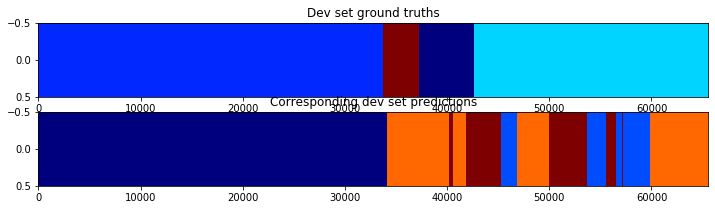

In [20]:
plt.figure(figsize=(12, 3))
Y_dev_lab = np.argmax(Y_dev, axis=-1)
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y_dev_lab[iix:iix+1,:].astype(int), aspect='auto', cmap='jet')

plt.subplot(212)
plt.title('Corresponding dev set predictions')
plt.imshow(Y_hat[iix:iix+1,:].astype(int), aspect='auto', cmap='jet')

In [21]:
np.where(np.argmax(Y_hat_p[iix,:,:], axis=-1)==3)

(array([], dtype=int64),)

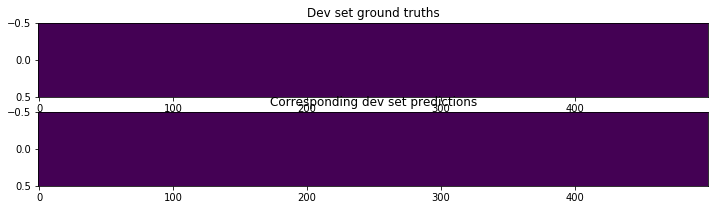

In [22]:
plt.figure(figsize=(12, 3))
Y_dev_lab = np.argmax(Y_dev, axis=-1)
plt.subplot(211)
plt.title('Dev set ground truths')
plt.imshow(Y_dev_lab[iix:iix+1,29000:29500].astype(int), aspect='auto')#, cmap='jet')

plt.subplot(212)
plt.title('Corresponding dev set predictions')
plt.imshow(Y_hat[iix:iix+1,29000:29500].astype(int), aspect='auto')#, cmap='jet')

In [23]:
Y_hat_p[iix,np.where(np.argmax(Y_hat_p[iix,:,:], axis=-1)==3),:]

array([], shape=(1, 0, 7), dtype=float32)

In [24]:
# seems like a crf-smoother (even a post-hoc one) could really help